# All library imports 

In [26]:
# Standard Library Imports
import os
from collections import Counter

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns  # Optional for better color palettes

# Machine Learning and Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE


# 1. Determining Dataset count and visualization of Un/Balanced 

Counts of .wav files in each label folder:
Angry: 1016
Disgust: 1016
Fear: 1016
Happy: 1016
Neutral: 707
Sad: 1017
Surprise: 652


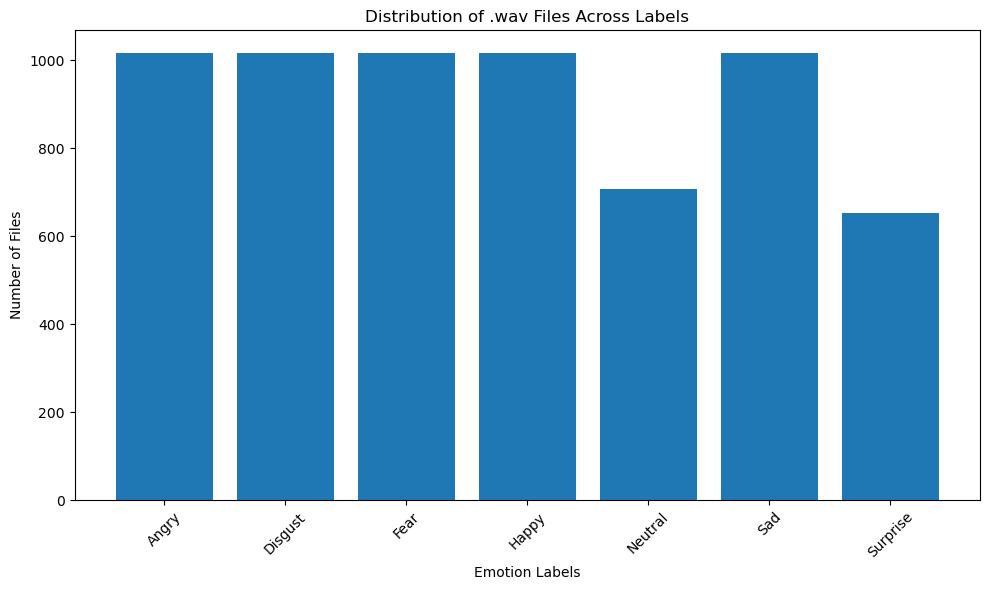

In [27]:
# Input folder containing labeled subfolders
input_folder = "../data"

# Initialize a counter for label counts
label_counts = Counter()

# Walk through the directory
for root, _, files in os.walk(input_folder):
    label = os.path.basename(root)  # Use the folder name as the label
    wav_count = sum(1 for file in files if file.endswith(".wav"))
    if wav_count > 0:  # Only count folders with .wav files
        label_counts[label] += wav_count

# Sort the labels alphabetically for better visualization
sorted_labels = sorted(label_counts.keys())
sorted_counts = [label_counts[label] for label in sorted_labels]

# Print counts
print("Counts of .wav files in each label folder:")
for label in sorted_labels:
    print(f"{label}: {label_counts[label]}")
    
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_counts)
plt.xlabel("Emotion Labels")
plt.ylabel("Number of Files")
plt.title("Distribution of .wav Files Across Labels")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Most Labels Are Balanced, for unbalanced classes we will use ƛ (lambda) for the loss function or use SMOTE (Synthetic Minority Oversampling)

- Labels  Angry, Disgust, Fear, Happy, and Sad are balanced
- Neutral has 707 files, which is ~30% fewer than the dominant classes.
- Surprise has 652 files, ~35% fewer than the dominant classes.

## Use of Smote 

In [28]:
# Load dataset
data = pd.read_csv("../notebooks/main_extracted_features.csv")

# Extract features and labels
feature_columns = [col for col in data.columns if col != 'Label']
X = data[feature_columns]
y = data['Label']  # Assuming 'Label' contains the target emotion labels

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Check the new class distribution
balanced_counts = Counter(y_smote)
print("Class distribution after SMOTE:", balanced_counts)

# Convert back to DataFrame for further processing
X_smote_df = pd.DataFrame(X_smote, columns=feature_columns)
y_smote_df = pd.DataFrame(y_smote, columns=['Label'])

# Combine into a single DataFrame
balanced_data = pd.concat([X_smote_df, y_smote_df], axis=1)

balanced_data.to_csv("balanced_dataset.csv", index=False)
print("Balanced dataset saved to 'balanced_dataset.csv'")

Class distribution after SMOTE: Counter({3: 1017, 5: 1017, 2: 1017, 6: 1017, 4: 1017, 0: 1017, 1: 1017})
Balanced dataset saved to 'balanced_dataset.csv'


---

## Code for the output and visualization of features

/var/folders/k5/_41yzt6n5nsck7fcy_m0950w0000gn/T/ipykernel_49476/1250576640.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


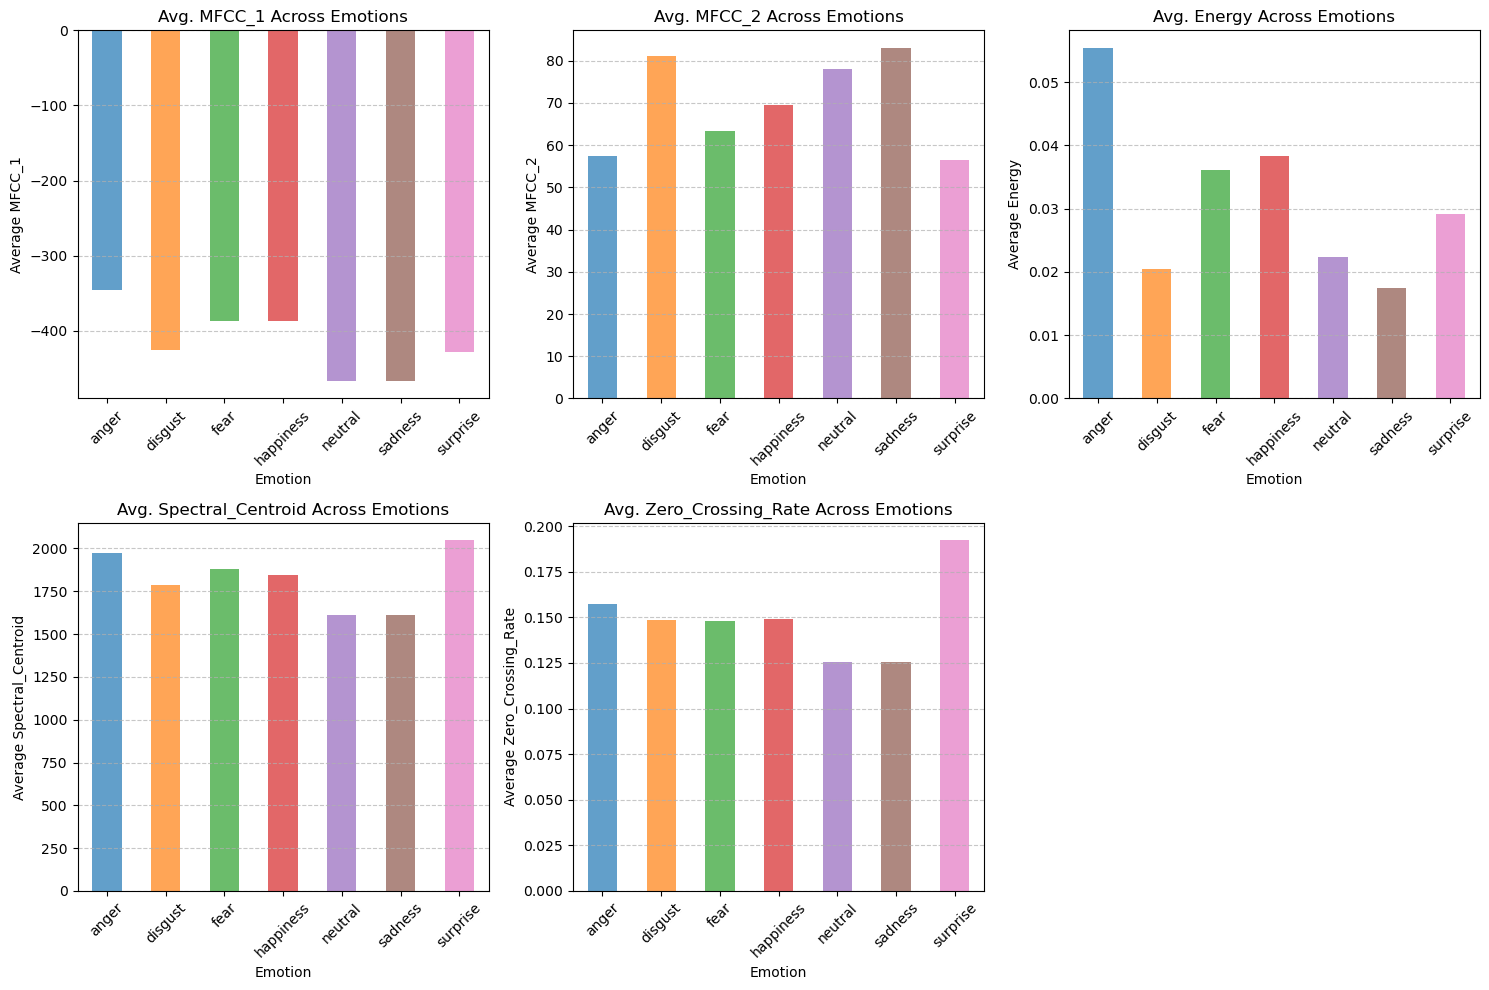

In [29]:
# Load Dataset
data = pd.read_csv('../notebooks/main_extracted_features.csv')

# Mapping labels to emotion names
label_mapping = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'neutral',
    5: 'sadness',
    6: 'surprise'
}

# Add emotion labels to the dataframe
data['Emotion'] = data['Label'].map(label_mapping)

# Function to calculate average features for each label
def calculate_average_features(data):
    grouped_data = data.groupby('Emotion').mean()
    return grouped_data

# Function to visualize features across labels with a colormap
def visualize_features(data):
    avg_features = calculate_average_features(data)
    
    # Select features to plot
    features_to_plot = ['MFCC_1', 'MFCC_2', 'Energy', 'Spectral_Centroid', 'Zero_Crossing_Rate']

    # Use a colormap for consistent coloring
    cmap = get_cmap('tab10')
    emotion_colors = {emotion: cmap(i) for i, emotion in enumerate(avg_features.index)}

    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features_to_plot, 1):
        plt.subplot(2, 3, i)

        # Bar plot for average feature values per label
        colors = [emotion_colors[emotion] for emotion in avg_features.index]
        avg_features[feature].plot(kind='bar', color=colors, alpha=0.7, rot=45)
        
        plt.title(f"Avg. {feature} Across Emotions")
        plt.ylabel(f"Average {feature}")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Visualize features
visualize_features(data)

Top Left: MFCC (Mel-Frequency Cepstral Coefficients)
- MFCCs are derived from the spectral properties of the audio, capturing the timbre of the voice.
- Peaks and valleys in MFCC values indicate variations in speech timbre for different emotions.

Top Right: Spectral Centroid
- Shows the "brightness" of the audio, representing the average frequency at which most energy is concentrated.
- Higher centroid values indicate more high-frequency content, likely caused by higher pitch or sharp tones. Lower centroid values correspond to softer, lower-pitched speech.

Bottom Left: RMS (Root Mean Square Energy)
- Shows the average loudness or energy of the audio for each emotion.
    - Angry and Happy have the highest energy levels, consistent with their dynamic and loud expressions.
    - Disgust and Sad have the lowest energy levels, correlating with their softer and quieter tones.

Bottom Right: ZCR (Zero-Crossing Rate)
- Shows the rate at which the audio signal crosses zero amplitude, measuring noisiness or percussiveness.
    - Surprise has the highest ZCR, suggesting noisier or more abrupt transitions in the speech signal.

## Tips for Better Performance in training
- Normalize Features: Scale features to a uniform range (e.g., 0–1 or standardize with mean=0, variance=1).
- Reduce Dimensionality: Use PCA or feature selection methods to focus on the most relevant features.
- Use Class-Specific Weights: Address imbalances in emotional class distribution.

# 2. Data Overview and Cleaning

In [30]:
# Load the dataset
data = pd.read_csv("../notebooks/main_extracted_features.csv")

In [31]:
# Check for missing values
missing_values = sum(data.isnull().sum())
print(f"Missing values: {missing_values}")

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Missing values: 0
Number of duplicate rows: 0


In [32]:
# Summary statistics for vairance
print("\nStandard Deviation of Features:")
print(data.describe().loc['std'])


Standard Deviation of Features:
MFCC_1                109.466051
MFCC_2                 32.213105
MFCC_3                 20.548651
MFCC_4                 14.375194
MFCC_5                 12.315410
MFCC_6                  8.185210
MFCC_7                  8.640705
MFCC_8                  5.783332
MFCC_9                  5.832198
MFCC_10                 5.755968
MFCC_11                 5.604625
MFCC_12                 4.221392
MFCC_13                 4.730343
Delta_MFCC_1            1.249231
Delta_MFCC_2            1.139908
Delta_MFCC_3            0.476938
Delta_MFCC_4            0.449221
Delta_MFCC_5            0.388880
Delta_MFCC_6            0.291924
Delta_MFCC_7            0.268078
Delta_MFCC_8            0.197825
Delta_MFCC_9            0.263785
Delta_MFCC_10           0.215237
Delta_MFCC_11           0.211868
Delta_MFCC_12           0.167441
Delta_MFCC_13           0.159137
Delta2_MFCC_1           1.072532
Delta2_MFCC_2           0.407821
Delta2_MFCC_3           0.238133
Delta2_MFC

- The MFCCs (MFCC_1 to MFCC_13), Delta-MFCCs, and Delta2-MFCCs have diverse ranges and variance, suggesting they capture useful variability in audio features.
- The Energy feature has a wide range but relatively small mean values, indicating its effectiveness in capturing amplitude dynamics.
- Spectral features (Spectral_Centroid, Spectral_Bandwidth, Spectral_Rolloff) show meaningful variation, capturing differences in frequency distribution across samples.
- Zero_Crossing_Rate has a mean of 0.148, reflecting noisiness and tonal changes in the audio, which could differentiate emotions.

# 3. Correlation & Feature Distibution Analysis

## EDA is easier when data is standardized

In [33]:
data = pd.read_csv("../notebooks/main_extracted_features.csv")

# Extract features (exclude 'Label' if it's a target variable)
feature_columns = [col for col in data.columns if col != 'Label']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[feature_columns])

# Convert back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=feature_columns)


Correlation: A measure of how strongly two variables are related (ranges from -1 to 1):
- 1: Perfect positive correlation (as one increases, the other increases).
- -1: Perfect negative correlation (as one increases, the other decreases).
- 0: No correlation.

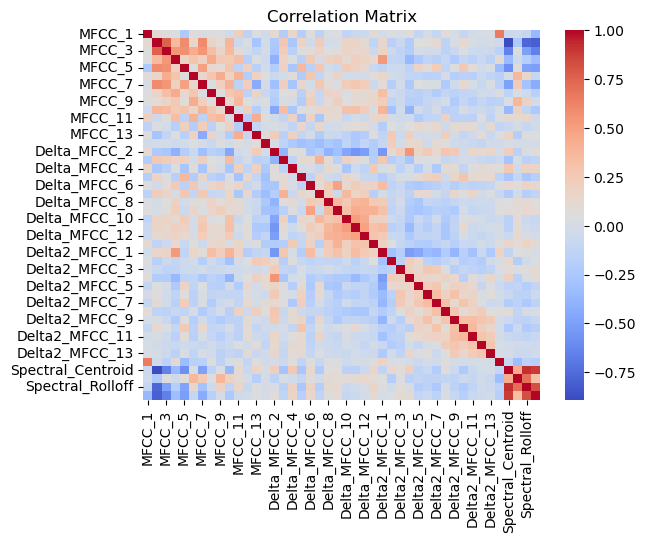

Highly correlated features: {'Spectral_Rolloff'}


In [34]:
# Correlation matrix
correlation_matrix = scaled_data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# High correlation pairs (threshold > 0.85)
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.90:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(f"Highly correlated features: {correlated_features}")

 **Spectral_Rolloff shares a strong linear relationship with another feature(s). It means that the feature Spectral_Rolloff is highly correlated (correlation magnitude > 0.90) with one or more other features in the dataset. If needed to increase accuracy of model it dropping Spectral_Rolloff or the other correlated feature(s).**

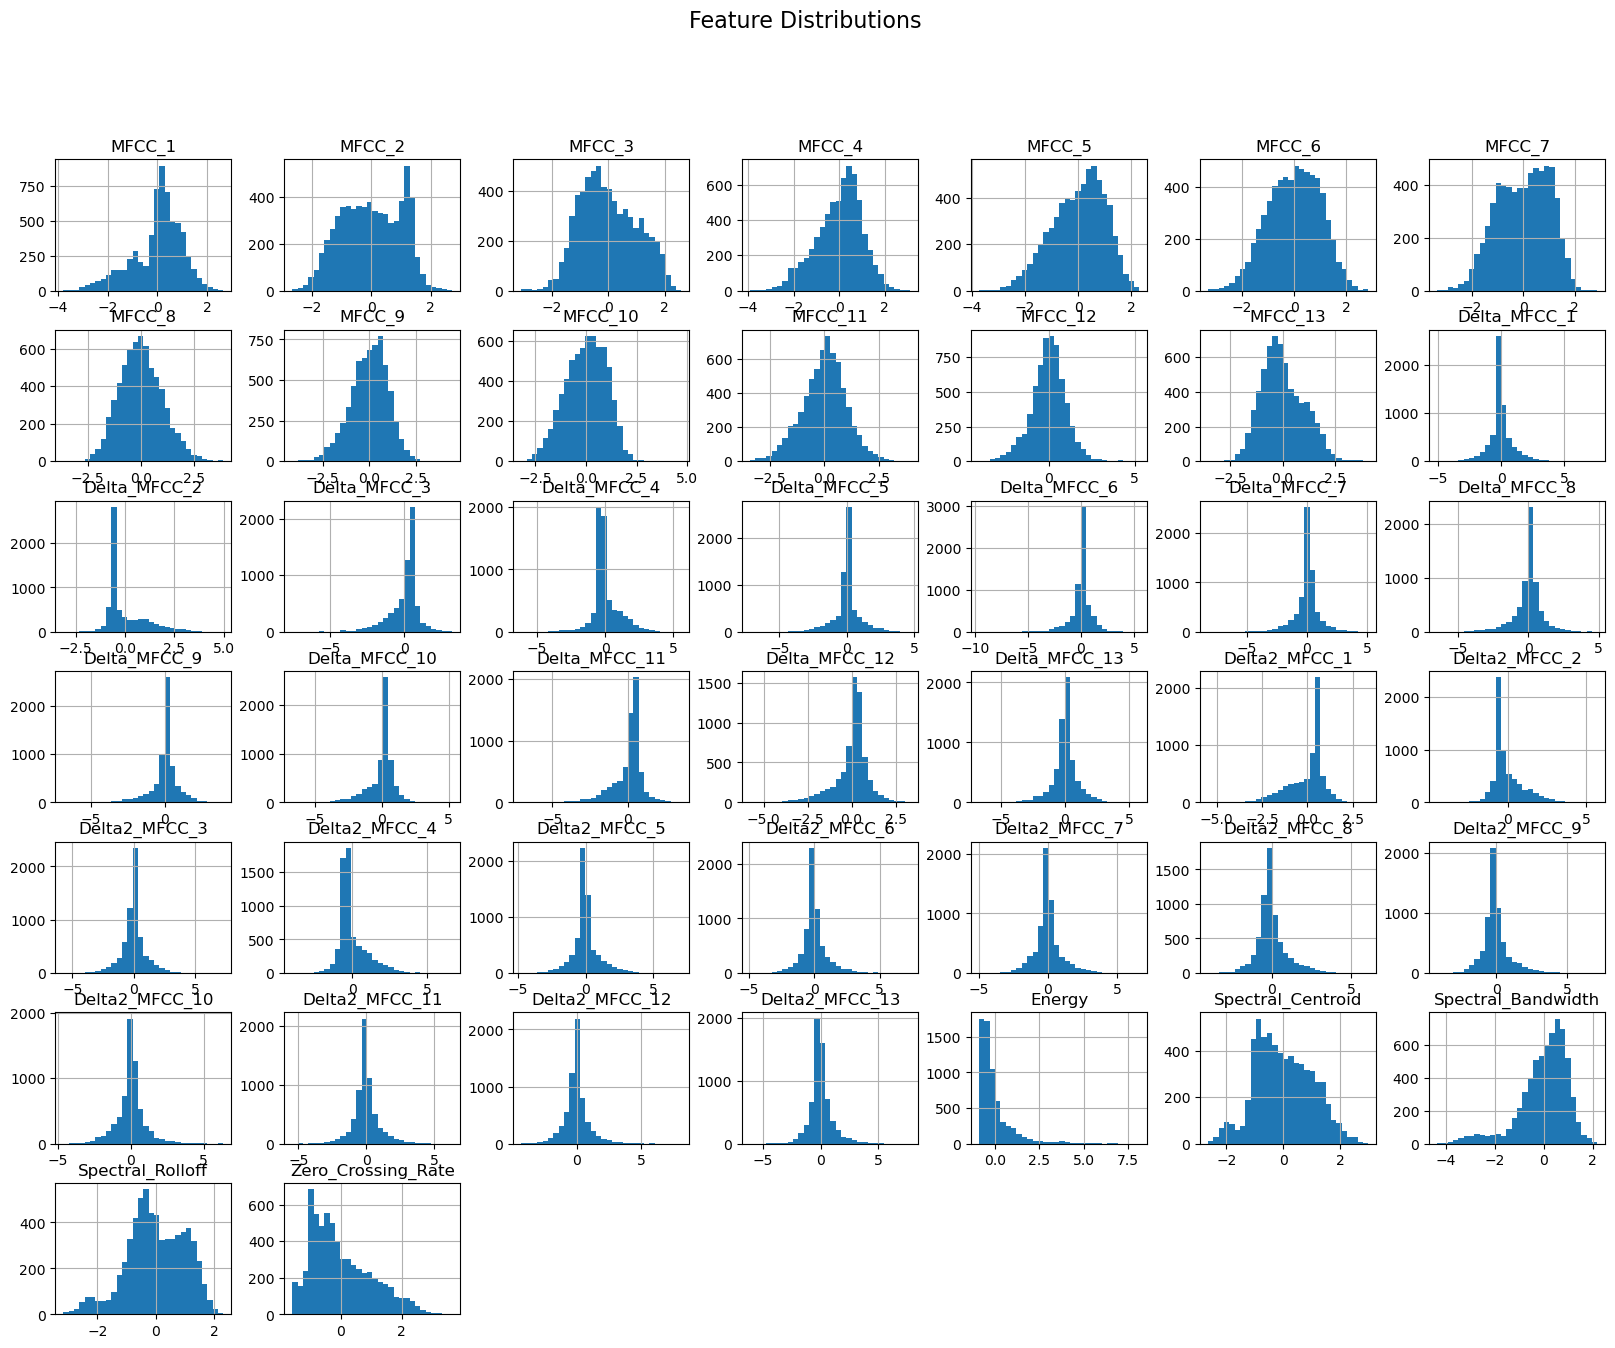

In [35]:
# Histograms
num_features = scaled_data.select_dtypes(include=[np.number]).columns
scaled_data[num_features].hist(figsize=(20, 15), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

**Majority of the features present a distibution. With the exception of Energy, Spectral Rolloff, Zero Crossing Rate, these features present skewdness which might display outliers are present in these features. If Model training does not increase with parameter training we will need to perform furter Feature Analysis on them.** 

# 4. Dimensionality Reduction / Feature Visualization

In [36]:
data = pd.read_csv("../notebooks/main_extracted_features.csv")
balanced_data = pd.read_csv("../notebooks/smote_balanced_dataset.csv")

# Extract features (exclude 'Label' if it's a target variable)
feature_columns = [col for col in data.columns if col != 'Label']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[feature_columns])

# Convert back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=feature_columns)


## Linear Visualization (PCA)

**This aids to visuallize the dataset on 2-d and 3-d plots** 

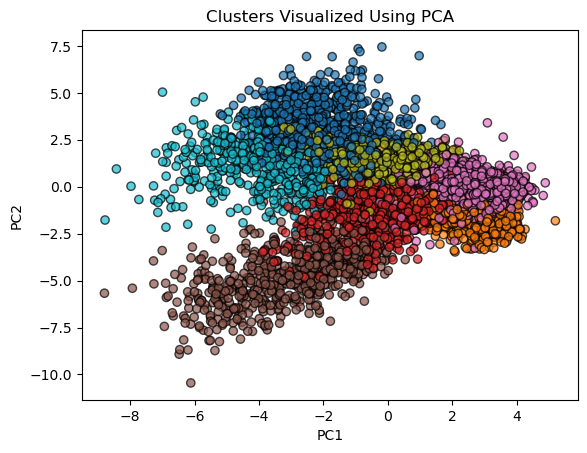

In [37]:
# Perform clustering on the original dataset
kmeans = KMeans(n_clusters=7, random_state=42) 
labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the data for visualization
scaled_data['Cluster'] = labels

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data.drop(columns=['Cluster']))

# Visualize the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', alpha=0.7, edgecolor='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters Visualized Using PCA')
plt.show()


**For this Plot we can see the clustering of the 7 different emotions, however with lots of overlapping. This overlapping represents that the dataset has a Nonlinear relationship. PCA - Kmeans will not work.**

## Non-Linear Visualization (t-sne)

Non-linear Dimenisionality Reduction using t-SNE (t-Distributed Stochastic Neighbor Embedding). t-SNE calculates the similarity between data points in the high-dimensional space based on a probability distribution (using Gaussian kernels)

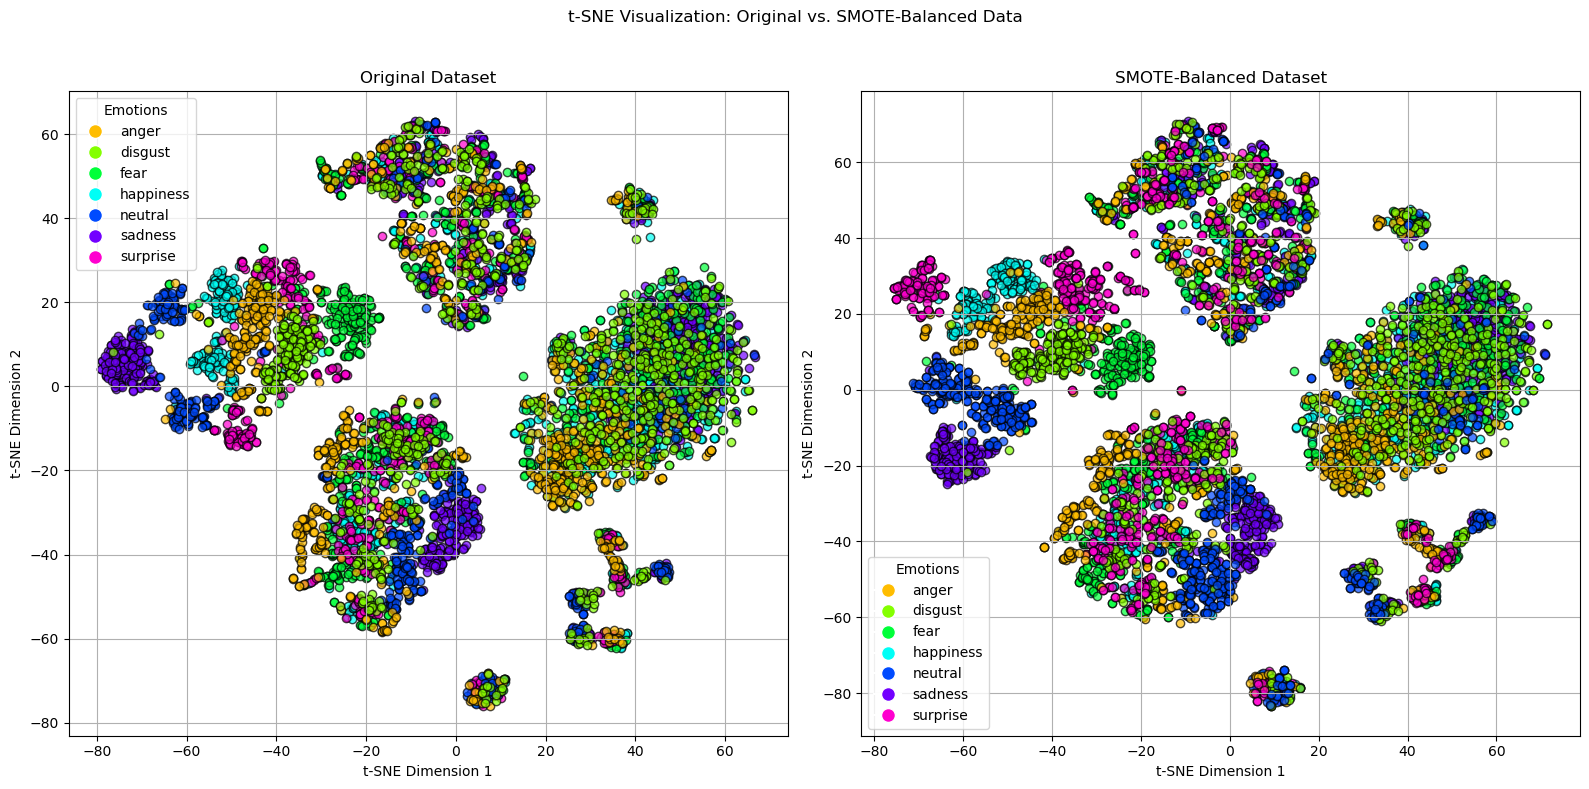

In [38]:
# Load the datasets
data = pd.read_csv("../notebooks/main_extracted_features.csv")
balanced_data = pd.read_csv("../notebooks/smote_balanced_dataset.csv")

# Label mapping and color mapping
label_mapping = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'neutral',
    5: 'sadness',
    6: 'surprise'
}

colors = sns.color_palette('hsv', len(label_mapping))  # Generate a color palette
color_mapping = {key: colors[key] for key in label_mapping}

# Extract features and labels
original_features = data.drop(columns=['Label'])  # Drop the 'Label' column for features
original_labels = data['Label']  # Extract labels from the original dataset

balanced_features = balanced_data.drop(columns=['Label'])  # Drop the 'Label' column for features
balanced_labels = balanced_data['Label']  # Extract labels from the balanced dataset

scaler = StandardScaler()
original_features_scaled = scaler.fit_transform(original_features)
balanced_features_scaled = scaler.fit_transform(balanced_features)

# Perform t-SNE for both datasets
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
original_tsne = tsne.fit_transform(original_features_scaled)
balanced_tsne = tsne.fit_transform(balanced_features_scaled)

# Convert results to DataFrames
original_tsne_df = pd.DataFrame(original_tsne, columns=['TSNE Dimension 1', 'TSNE Dimension 2'])
original_tsne_df['Label'] = original_labels

balanced_tsne_df = pd.DataFrame(balanced_tsne, columns=['TSNE Dimension 1', 'TSNE Dimension 2'])
balanced_tsne_df['Label'] = balanced_labels

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot original dataset
axes[0].set_title('Original Dataset')
for index, row in original_tsne_df.iterrows():
    axes[0].scatter(
        row['TSNE Dimension 1'],
        row['TSNE Dimension 2'],
        color=color_mapping[row['Label']],
        alpha=0.7,
        edgecolor='k'
    )

# Add legend to the first plot
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[key], markersize=10, label=label)
    for key, label in label_mapping.items()
]
axes[0].legend(handles=handles, title="Emotions", loc="best")
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
axes[0].grid()

# Plot SMOTE-balanced dataset
axes[1].set_title('SMOTE-Balanced Dataset')
for index, row in balanced_tsne_df.iterrows():
    axes[1].scatter(
        row['TSNE Dimension 1'],
        row['TSNE Dimension 2'],
        color=color_mapping[row['Label']],
        alpha=0.7,
        edgecolor='k'
    )

# Add legend to the second plot
axes[1].legend(handles=handles, title="Emotions", loc="best")
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].grid()

# Display the plots
plt.suptitle('t-SNE Visualization: Original vs. SMOTE-Balanced Data')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The plot shows well-separated clusters, indicating that the t-SNE algorithm effectively captured the structure of the dataset. With the overlapping emotions it presents that there is shared features or characteristics in the data for these emotions.

**This representation does not clearly seperate the coresponding emotions, we are going to do a non-linear approach to sperate the classes. Lot of overlapping can indicate a non-linear relationship of the features.** 

**T-SNE applied to PCA-transformed data demonstrates the presence of distinct clusters within the dataset, providing the best clustering visualization.**